In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import PIL as pil
from sklearn import metrics, preprocessing
import cv2
import shap
import lime
from skimage.segmentation import mark_boundaries

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
train_dir = os.path.join('dataset', 'images', 'train_class')
test_dir = os.path.join('dataset', 'images', 'val_class')

In [8]:
img_height = 224
img_width = 224
num_classes = 8
batch_size = 32
Classes = ['neutral', 'happy', 'sad', 'surprised', 'fear', 'disgusted', 'angry', 'contempt']

In [9]:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  rotation_range=60,
                                  rescale=1./255,
                                  validation_split=0.3)

test_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.3)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size= batch_size,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = test_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size= batch_size,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='validation')

test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size= batch_size,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical')

Found 26288 images belonging to 8 classes.
Found 11265 images belonging to 8 classes.
Found 4000 images belonging to 8 classes.


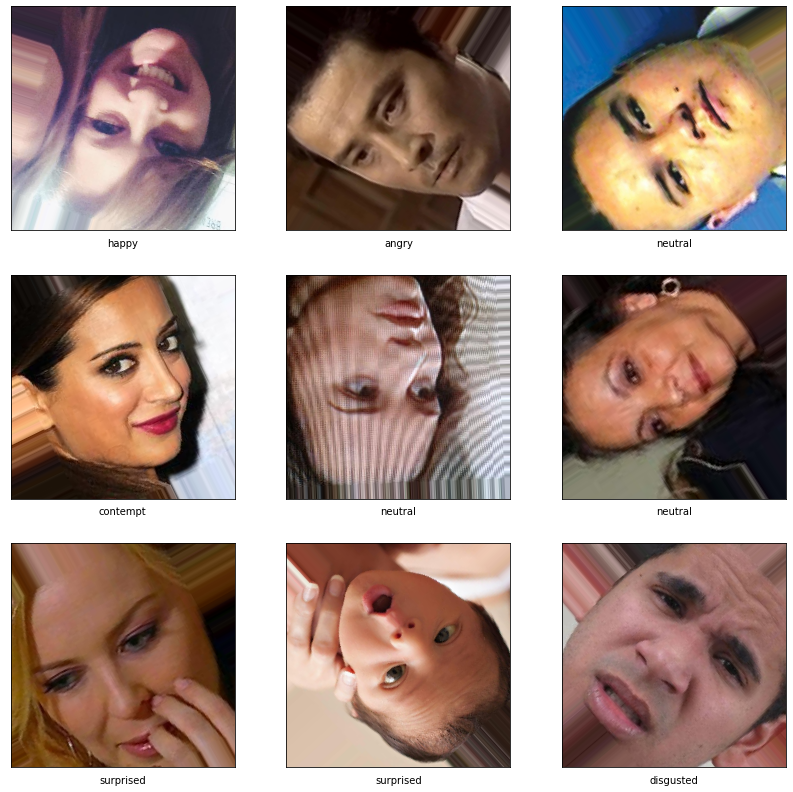

In [10]:
image, classes = next(train_generator)

class_idxs = np.argmax(classes, axis=-1) 
labels = [Classes[idx] for idx in class_idxs]

plt.figure(figsize=(14, 14))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((image[i]))
    plt.xlabel(f'{labels[i]}')
plt.show()

In [11]:
def alexNet(inputs):
    #inputs = tf.keras.layers.Input(shape= (img_height, img_width, 3))
    x = Conv2D(filters= 48,kernel_size=(3, 3), strides=2, activation = 'relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    x = Conv2D(filters = 96, kernel_size=(3, 3), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    x = Conv2D(filters = 128, kernel_size=(3, 3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(filters = 128, kernel_size=(3, 3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(filters = 96, kernel_size=(3, 3), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(512, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dense(512, activation= 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    return x

In [12]:
def define_model():
    inputs = tf.keras.layers.Input(shape= (img_height, img_width, 3))
    outputs = alexNet(inputs)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    
    model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate= 0.01, momentum=0.9),
                 loss = tf.keras.losses.categorical_crossentropy,
                 metrics = ['accuracy'])
    
    return model

In [17]:
alexNet_model = define_model()

In [10]:
alexNet_model = tf.keras.models.load_model(os.path.join('trained_models', 'AlexNet.h5'))

In [ ]:
aN_checkpoint_path = os.path.join('training', 'Alex\ ')
aN_callback = tf.keras.callbacks.ModelCheckpoint(filepath=aN_checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = alexNet_model.fit(x = train_generator, validation_data = validation_generator, callbacks = [aN_callback],
                                 epochs=20)

Epoch 1/20
822/822 [==============================] - ETA: 0s - loss: 6.3226 - accuracy: 0.1325
Epoch 1: saving model to training\Alex\ 
822/822 [==============================] - 189s 229ms/step - loss: 6.3226 - accuracy: 0.1325 - val_loss: 2.0733 - val_accuracy: 0.1332
Epoch 2/20
381/822 [============>.................] - ETA: 1:30 - loss: 2.0750 - accuracy: 0.1302

In [18]:
alexNet_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001, momentum = 0.9),
                     loss=tf.keras.losses.categorical_crossentropy,
                     metrics=['accuracy'])

In [11]:
alexNet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 54, 54, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 128)       307328    
                                                                 
 batch_normalization_1 (Batc  (None, 23, 23, 128)      512   

In [12]:
alexNet_model.evaluate(test_generator)

125/125 [==============================] - 12s 67ms/step - loss: 1.7773 - accuracy: 0.4652


[1.777349591255188, 0.4652499854564667]

1/1 [==============================] - 0s 31ms/step


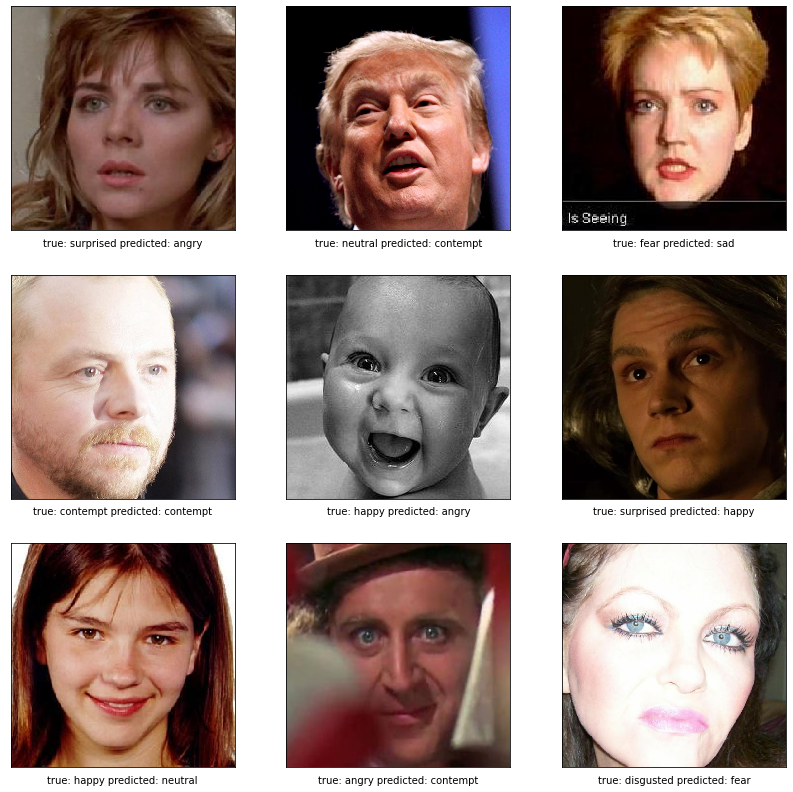

In [15]:
test_image, test_classes = next(test_generator)
prediction = alexNet_model.predict(test_image)

predictions = np.argmax(prediction, axis = -1)

class_idxs = np.argmax(classes, axis=-1) 
labels = [Classes[idx] for idx in class_idxs]
predictions_label = [Classes[idx] for idx in predictions]

plt.figure(figsize=(14, 14))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((image[i]))
    plt.xlabel(f'true: {labels[i]} predicted: {predictions_label[i]}')
plt.show()

In [25]:
def shap_xai(img):
    def f(X):
        tmp = X.copy()
        return alexNet_model(tmp)

    masker = shap.maskers.Image("inpaint_telea", test_image[0].shape)

    explainer = shap.Explainer(f, masker, ouput_names = Classes)

    shap_values = explainer(img[:1], max_evals=1000, batch_size=16, outputs=shap.Explanation.argsort.flip[:1])
    shap.image_plot(shap_values)

In [26]:
def lime_xai(img):
    explainer_lime = lime_image.LimeImageExplainer()

    explanation = explainer_lime.explain_instance(img.astype('double'), 
                                                  alexNet_model.predict, 
                                                  top_labels=8, 
                                                  hide_color=0, 
                                                  num_samples=1000)
    
    print("Masked region of image: ")
    
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                positive_only=True, 
                                                num_features=8, hide_rest=True)
    plt.imshow(mark_boundaries(temp, mask))
    plt.show()
    
    print("A heat of the image for most favoured label: ")
    
    #Select the same class explained on the figures above.
    ind =  explanation.top_labels[0]

    #Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

    #Plot. The visualization makes more sense if a symmetrical colorbar is used.
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.show()

# Correct Predictions with Shap

  0%|          | 0/998 [00:00<?, ?it/s]

Partition explainer: 2it [00:16, 16.87s/it]                                                                            


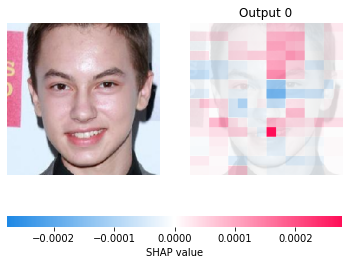

true: contempt  predicted: contempt


  0%|          | 0/998 [00:00<?, ?it/s]

Partition explainer: 2it [00:22, 22.65s/it]                                                                            


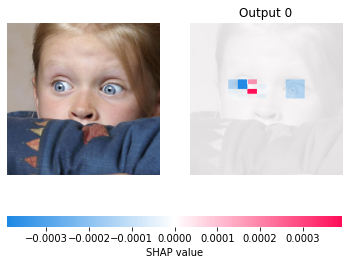

true: fear  predicted: fear


  0%|          | 0/998 [00:00<?, ?it/s]

Partition explainer: 2it [00:17, 17.71s/it]                                                                            


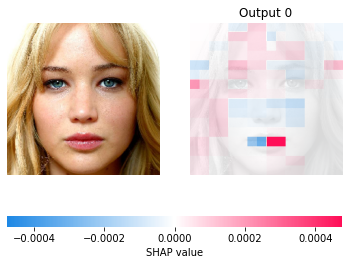

true: neutral  predicted: neutral


  0%|          | 0/998 [00:00<?, ?it/s]

Partition explainer: 2it [00:17, 17.60s/it]                                                                            


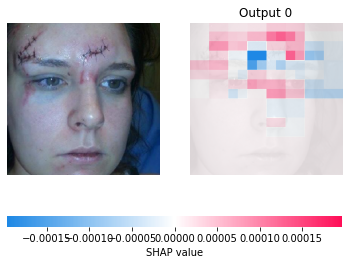

true: sad  predicted: sad


  0%|          | 0/998 [00:00<?, ?it/s]

Partition explainer: 2it [00:16, 16.75s/it]                                                                            


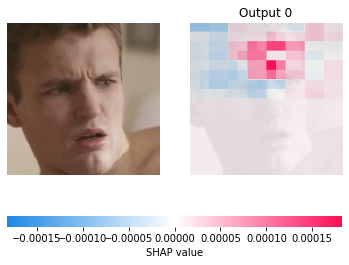

true: sad  predicted: sad


In [27]:
count = 0

for i in range(32):
    if predictions_label[i] == labels[i]:
        shap_xai(test_image[i : i+1])
        print(f'true: {labels[i]}  predicted: {predictions_label[i]}')
        count += 1
        if count == 5:
            break

# Wrong Predictions with Shap

  0%|          | 0/998 [00:00<?, ?it/s]

Partition explainer: 2it [00:27, 27.53s/it]                                                                            


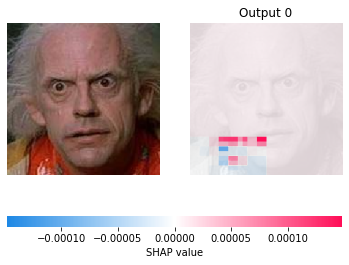

true: surprised  predicted: angry


  0%|          | 0/998 [00:00<?, ?it/s]

Partition explainer: 2it [00:17, 17.83s/it]                                                                            


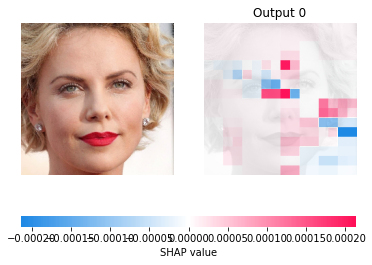

true: neutral  predicted: contempt


  0%|          | 0/998 [00:00<?, ?it/s]

Partition explainer: 2it [00:28, 28.10s/it]                                                                            


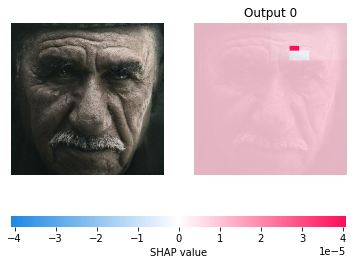

true: fear  predicted: sad


In [28]:
count = 0

for i in range(32):
    if predictions_label[i] != labels[i]:
        shap_xai(test_image[i : i+1])
        print(f'true: {labels[i]}  predicted: {predictions_label[i]}')
        count += 1
        if count == 3:
            break

# Correct Predictions with Lime

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step
Masked region of image: 


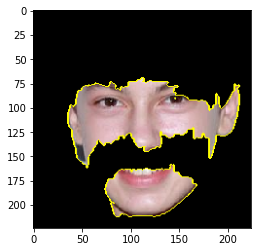

A heat of the image for most favoured label: 


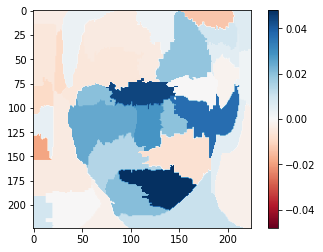

true: contempt  predicted: contempt


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step
Masked region of image: 


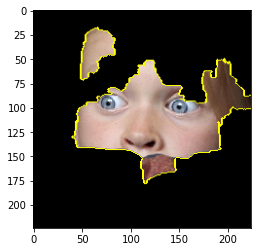

A heat of the image for most favoured label: 


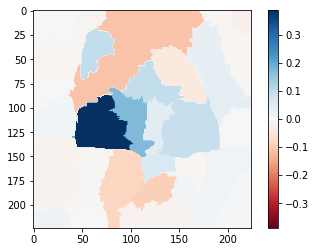

true: fear  predicted: fear


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step
Masked region of image: 


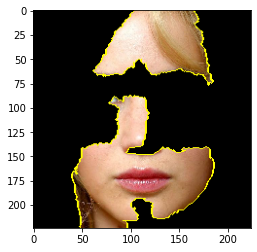

A heat of the image for most favoured label: 


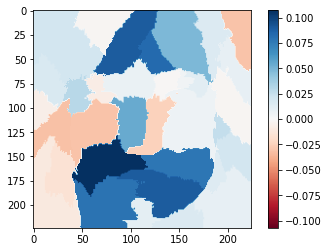

true: neutral  predicted: neutral


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step
Masked region of image: 


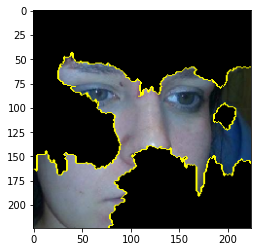

A heat of the image for most favoured label: 


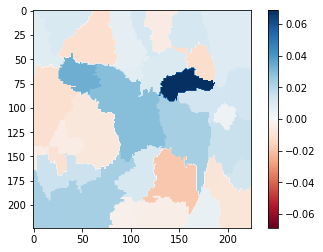

true: sad  predicted: sad


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step
Masked region of image: 


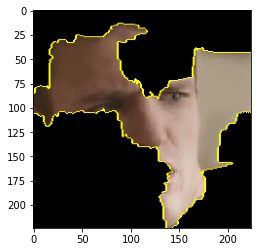

A heat of the image for most favoured label: 


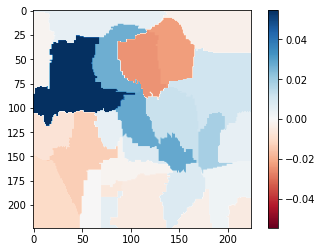

true: sad  predicted: sad


In [29]:
count = 0

for i in range(32):
    if predictions_label[i] == labels[i]:
        lime_xai(test_image[i])
        print(f'true: {labels[i]}  predicted: {predictions_label[i]}')
        count += 1
        if count == 5:
            break

# Wrong Predictions with Lime

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step
Masked region of image: 


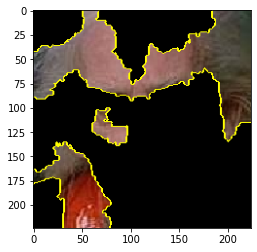

A heat of the image for most favoured label: 


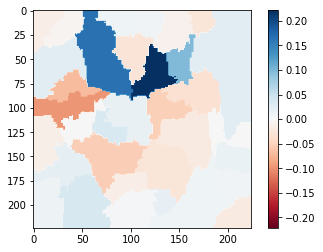

true: surprised  predicted: angry


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step
Masked region of image: 


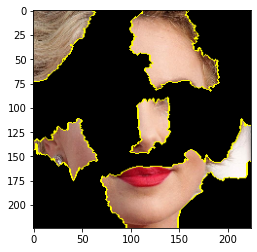

A heat of the image for most favoured label: 


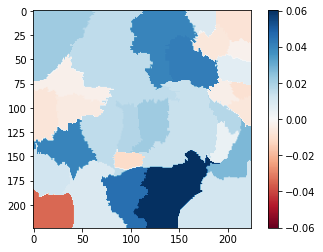

true: neutral  predicted: contempt


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step
Masked region of image: 


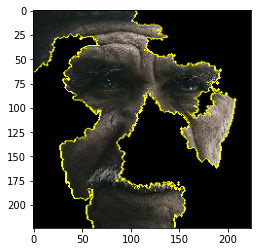

A heat of the image for most favoured label: 


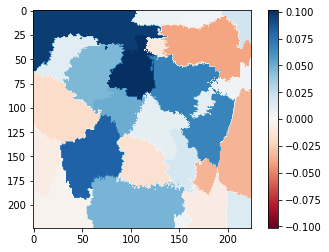

true: fear  predicted: sad


In [30]:
count = 0

for i in range(32):
    if predictions_label[i] != labels[i]:
        lime_xai(test_image[i])
        print(f'true: {labels[i]}  predicted: {predictions_label[i]}')
        count += 1
        if count == 3:
            break